In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

import matplotlib.pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/My Drive/Datasets/Segmentation/CamVid/"

TRAIN_IMG_PATH = PATH + "train"
TRAIN_MSK_PATH = PATH + "train_mask"
TEST_IMG_PATH = PATH + "test"
TEST_MSK_PATH = PATH + "test_mask"
VAL_IMG_PATH = PATH + "val"
VAL_MSK_PATH = PATH + "val_mask"

train_imgs = os.listdir(TRAIN_IMG_PATH)
mask_imgs = os.listdir(TRAIN_MSK_PATH)

test_imgs = os.listdir(TEST_IMG_PATH)
val_imgs = os.listdir(VAL_IMG_PATH)

print(len(train_imgs), len(test_imgs), len(val_imgs))

600 50 50


In [ ]:
BUFFER_SIZE = 600
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
EPOCHS = 300

In [ ]:
def resize(train_img, masked_img, height, width):
    train_img = tf.image.resize(train_img, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    masked_img = tf.image.resize(masked_img, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return train_img, masked_img

In [ ]:
def random_crop(train_img, masked_img):
    stacked_image = tf.stack([train_img, masked_img], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing the images to [-1, 1]
def normalize(train_img, masked_img):

    train_img = (train_img / 255)
    masked_img = (masked_img / 255)

    return train_img, masked_img

In [ ]:
@tf.function()
def img_augmentation(train_img, masked_img):

    train_img, masked_img = resize(train_img, masked_img, IMG_WIDTH+50, IMG_HEIGHT+50)

    train_img, masked_img = random_crop(train_img, masked_img)

    if tf.random.uniform(()) > 0.5:

        train_img = tf.image.flip_left_right(train_img)
        masked_img = tf.image.flip_left_right(masked_img)

    return train_img, masked_img

In [ ]:
# Image Loading
def load_train_image(filename, augment=True):
  
    train_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TRAIN_IMG_PATH + '/' + filename)), tf.float32)
    masked_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TRAIN_MSK_PATH + '/' + filename)), tf.float32)

    train_img, masked_img = resize(train_img, masked_img, IMG_HEIGHT, IMG_WIDTH)
    
    if augment:
        train_img, masked_img = img_augmentation(train_img, masked_img)
      
    train_img, masked_img = normalize(train_img, masked_img)
    
    return train_img, masked_img

def load_val_image(filename, augment=True):
  
    validation_imgs = tf.cast(tf.image.decode_jpeg(tf.io.read_file(VAL_IMG_PATH + '/' + filename)), tf.float32)
    validation_msks = tf.cast(tf.image.decode_jpeg(tf.io.read_file(VAL_MSK_PATH + '/' + filename)), tf.float32)

    validation_imgs, validation_msks = resize(validation_imgs, validation_msks, IMG_HEIGHT, IMG_WIDTH)
      
    validation_imgs, validation_msks = normalize(validation_imgs, validation_msks)
    
    return validation_imgs, validation_msks

def load_test_image(filename):
  
    test_imgs = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TEST_IMG_PATH + '/' + filename)), tf.float32)
    test_msks = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TEST_MSK_PATH + '/' + filename)), tf.float32)

    test_imgs, test_msks = resize(test_imgs, test_msks, IMG_HEIGHT, IMG_WIDTH)
      
    test_imgs, test_msks = normalize(test_imgs, test_msks)
    
    return test_imgs, test_msks

def load_train_img(filename):
    return load_train_image(filename, True)

def load_validation_img(filename):
    return load_val_image(filename)

def load_test_img(filename):
    return load_test_image(filename)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs)
train_dataset = train_dataset.map(load_train_image)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_imgs)
val_dataset = val_dataset.map(load_val_image)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)
test_dataset = test_dataset.map(load_test_img)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
def down_sample(input_layer, filters, pool=True):
    conv1 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(input_layer)
    residual = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(conv1)
    if pool:
        max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(residual)
        return max_pool, residual
    else:
        return residual

def up_sample(input_layer, residual, filters):
    upsample = tf.keras.layers.UpSampling2D()(input_layer)
    conv1 = tf.keras.layers.Conv2DTranspose(filters, (2, 2), activation='relu', padding='same')(upsample)
    concat = tf.keras.layers.Concatenate(axis=3)([residual, conv1])
    return concat

In [ ]:
def Unet_Generator():

    in_layer = tf.keras.layers.Input(shape = [256, 256, 3])

    level_1R, residual_1 = down_sample(in_layer, 64)
    level_2R, residual_2 = down_sample(level_1R, 128)
    level_3R, residual_3 = down_sample(level_2R, 256)
    level_4R, residual_4 = down_sample(level_3R, 512)

    latent_1 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(level_4R)
    latent_2 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(latent_1)

    level_4L = up_sample(latent_2, residual_4, 512)
    down_4L = down_sample(level_4L, 256, pool=False)
    level_3L = up_sample(down_4L, residual_3, 256)
    down_3L = down_sample(level_3L, 128, pool=False)
    level_2L = up_sample(down_3L, residual_2, 128)
    down_2L = down_sample(level_2L, 64, pool=False)
    level_1L = up_sample(down_2L, residual_1, 64)
    down_1L = down_sample(level_1L, 64, pool=False)

    out_layer = tf.keras.layers.Conv2D(3, (1, 1), activation='relu', padding='same')(down_1L)

    return tf.keras.Model(inputs=in_layer, outputs=out_layer)

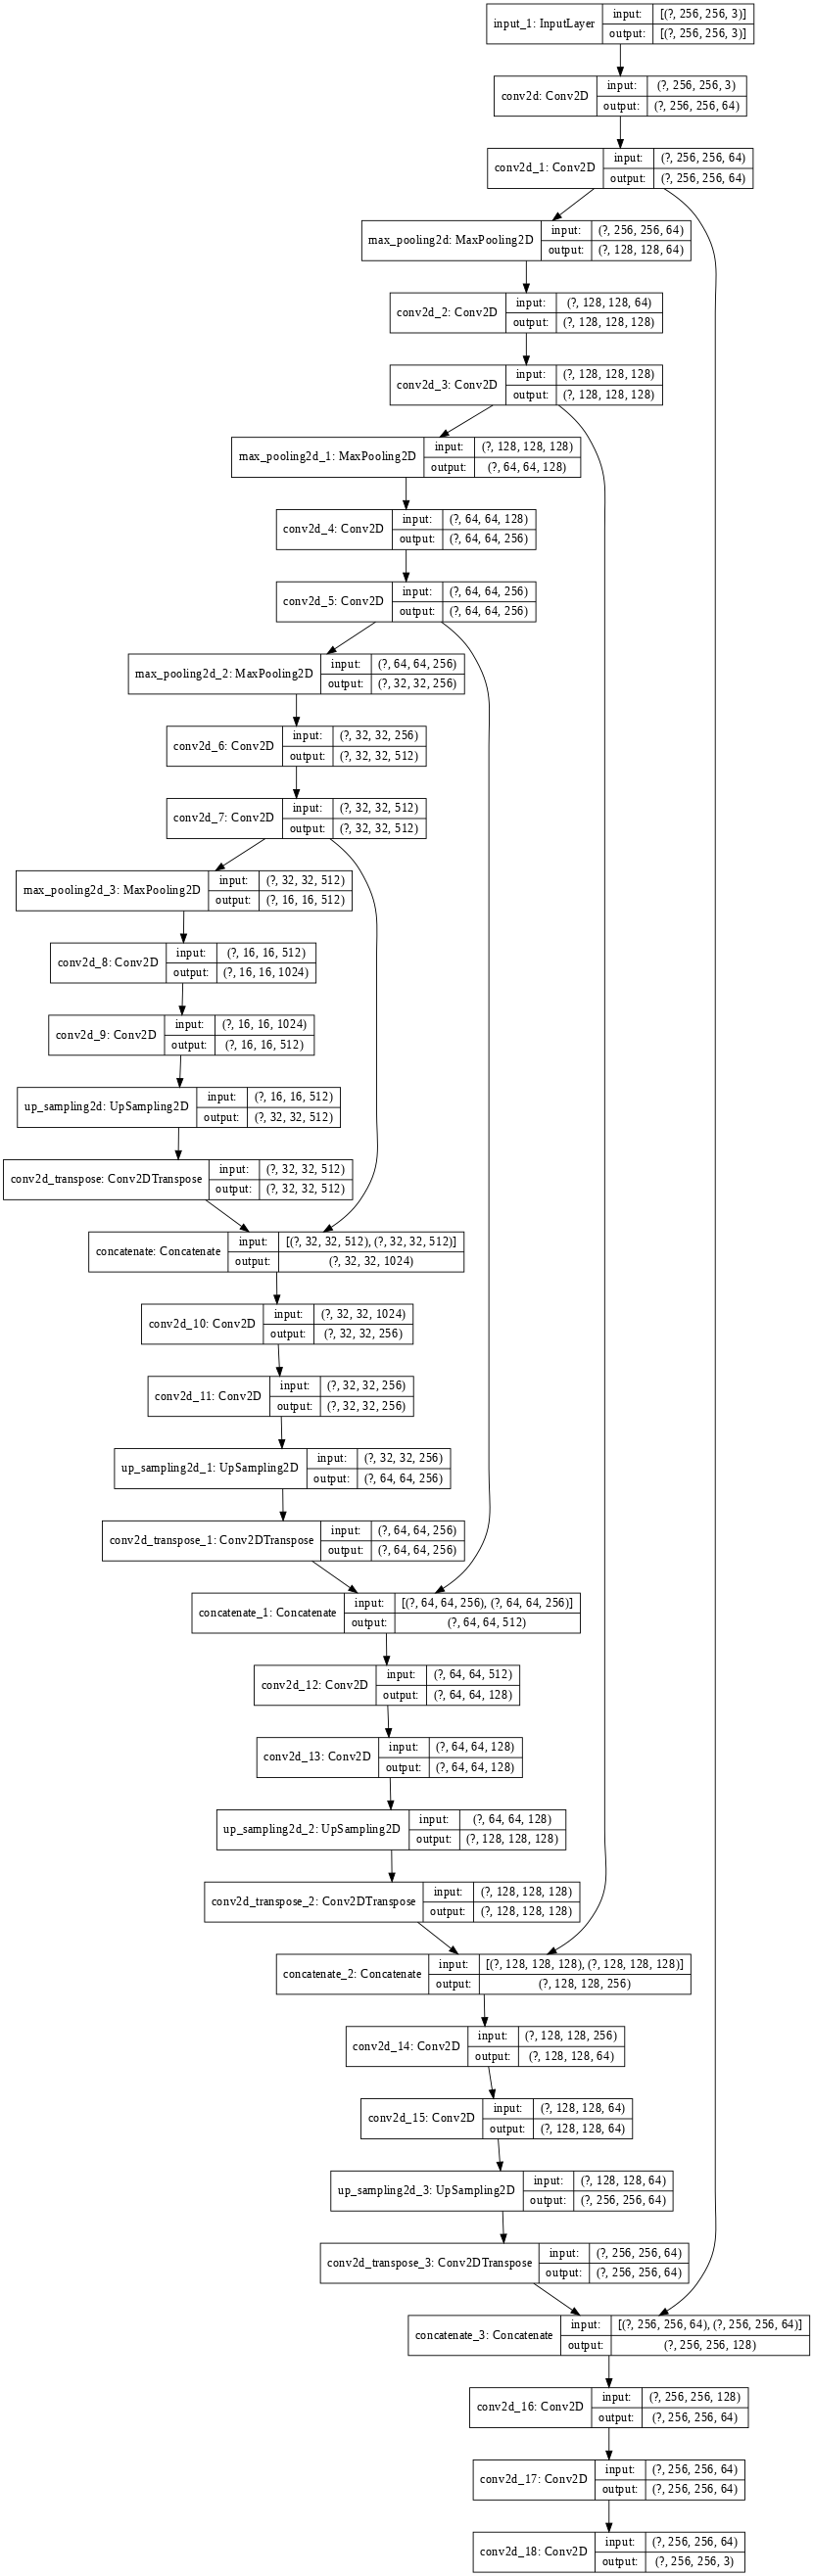

In [ ]:
generator = Unet_Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5

    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0, reduction="auto", 
                                         name="binary_crossentropy")
generator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=bce, metrics=[dice_coef])
history = generator.fit(train_dataset, batch_size=50, epochs=300, validation_data=val_dataset, verbose=1)

Epoch 1/300
60/60 [==============================] - 27s 446ms/step - loss: 0.7794 - dice_coef: 0.2130 - val_loss: 0.6433 - val_dice_coef: 0.2273
Epoch 2/300
60/60 [==============================] - 9s 151ms/step - loss: 0.6123 - dice_coef: 0.2161 - val_loss: 0.6223 - val_dice_coef: 0.2647
Epoch 3/300
60/60 [==============================] - 9s 150ms/step - loss: 0.5984 - dice_coef: 0.2401 - val_loss: 0.6129 - val_dice_coef: 0.2753
Epoch 4/300
60/60 [==============================] - 9s 150ms/step - loss: 0.5836 - dice_coef: 0.2869 - val_loss: 0.6018 - val_dice_coef: 0.2745
Epoch 5/300
60/60 [==============================] - 9s 150ms/step - loss: 0.5770 - dice_coef: 0.2899 - val_loss: 0.5955 - val_dice_coef: 0.4507
Epoch 6/300
60/60 [==============================] - 9s 150ms/step - loss: 0.5729 - dice_coef: 0.3537 - val_loss: 0.5923 - val_dice_coef: 0.1010
Epoch 7/300
60/60 [==============================] - 9s 151ms/step - loss: 0.5688 - dice_coef: 0.3675 - val_loss: 0.5875 - val_di

In [ ]:
def show_predictions(dataset, num=1):

    for image, mask in dataset.take(num):

        pred_mask = generator.predict(image)
        plt.figure(figsize=(15,15))

        display_list = [image[0], mask[0], pred_mask[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')

        plt.show()

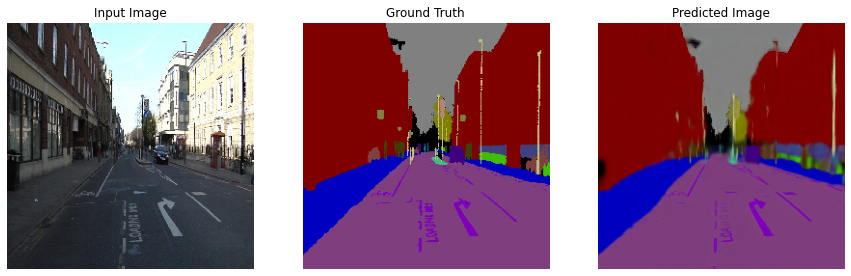

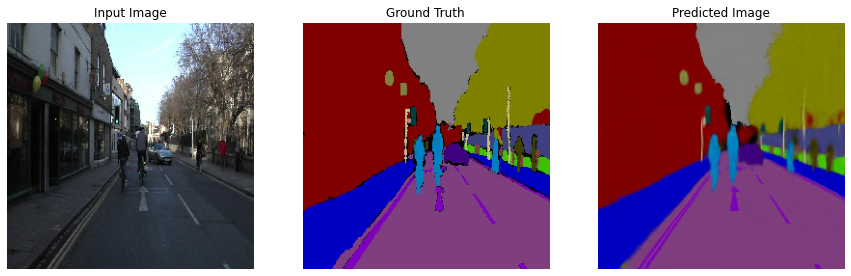

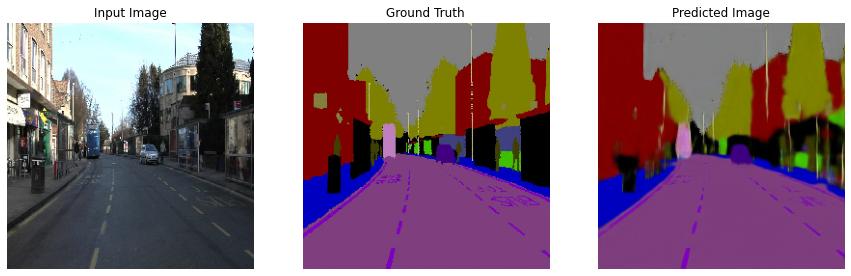

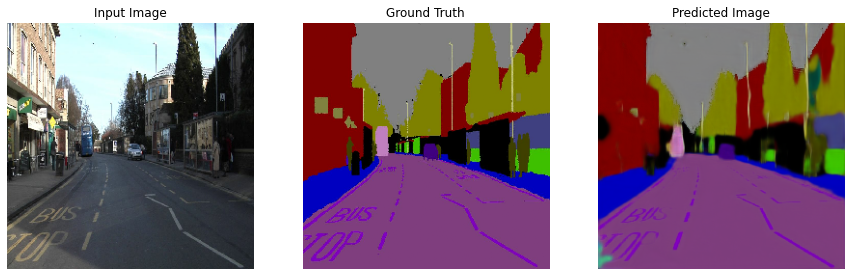

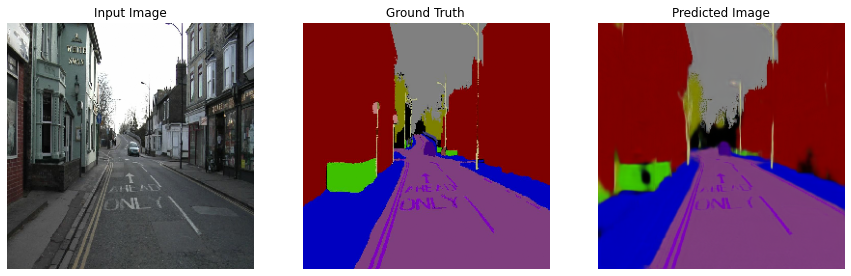

In [ ]:
show_predictions(test_dataset, 10)

[Text(0, 0.5, 'Dice Coefficient'), Text(0.5, 0, 'Epochs')]

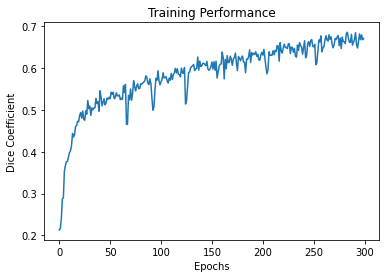

In [ ]:
# Plotting required curves
import pandas as pd
df = pd.DataFrame(history.history)

metric_plot = df.plot(y='dice_coef', title = 'Training Performance', legend = False)
metric_plot.set(xlabel='Epochs', ylabel='Dice Coefficient')

In [ ]:
generator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________